# Remote Sensing Image Segmentation

## Overview
This project focuses on using deep learning to segment remote sensing images which is important for applications like land cover mapping, city planning, and monitoring the environment.

## Objectives
- **Data Handling**: Create a custom data generator to read and prepare large images and their masks directly from the disk.
- **Model Training**: Build and train a deep learning model for image segmentation.
- **Performance Validation**: Check the model's accuracy and reliability using a separate validation dataset.
- **Model Evaluation**: Test the trained model on a new set of images, measure its performance, and visualize the results.

## Notebook Steps
1. **Data Preparation**: Organize the training and validation datasets. Use custom data generators to handle large image files and visualize some images and masks to ensure everything is correct.
2. **Model Compilation**: Design and compile a segmentation model with the right loss functions and performance metrics. Set up callbacks to monitor training.
3. **Model Training**: Train the model using the custom data generator, track the training process, and save the best model.
4. **Model Evaluation**: Test the trained model on a test dataset, calculate performance metrics like Intersection over Union (IoU) and Dice score, and visualize the results to see how well the model performs.


## Check GPU status

In [1]:
from utils import check_gpu_status

check_gpu_status()

Num GPUs Available: 1
1 Physical GPU(s), 1 Logical GPU(s)


## Data Preparation

### Variable Definitions

In this section, we define various variables that are essential for setting up the data pipeline and managing model training. These variables include parameters for data handling, directory paths, and filenames for saving models and logs.

In [2]:
import os
from custom_datagen import DataGenerator

batch_size = 4 # If the GPU memory allows, try to use bigger batch size
num_classes = 1
channels = {'R': 0, 'G': 1, 'B': 2, 'NIR': 3}

# Define the root directory
root_dir = r"F:\DEEP_LEARNING_GIS"
# data_dir = os.path.join(root_dir, "2019_Holdout")
data_dir = os.path.join(root_dir, "2023_3in_Holdout")
# Train Dataset
train_imgs = os.path.join(data_dir, "train", "images")
train_masks = os.path.join(data_dir, "train", "masks")

# Validation Dataset
val_imgs = os.path.join(data_dir, "val", "images")
val_masks = os.path.join(data_dir, "val", "masks")

# Define paths to output models and logs
model_name = "scSEResUNet_2023_v1.hdf5"
name_parts = model_name.split('.')
logfile_name = f"{name_parts[0]}_logs.csv"

model_path = os.path.join(root_dir, "Trained_Models", model_name)
log_path = os.path.join(root_dir, "Logs", logfile_name)

# Create directories if they do not exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(os.path.dirname(log_path), exist_ok=True)

print(f"Model will be saved to: {model_path}")
print(f"Logs will be saved to: {log_path}")


Model will be saved to: F:\DEEP_LEARNING_GIS\Trained_Models\scSEResUNet_2023_v1.hdf5
Logs will be saved to: F:\DEEP_LEARNING_GIS\Logs\scSEResUNet_2023_v1_logs.csv


### Initialize Data Generators

We initialize data generators for both the training and validation datasets using the `DataGenerator` class. This data generator is used for loading and preprocessing batches of images and masks for training U-Net models.

In [3]:
# Initialize data generators
train_gen = DataGenerator(
    img_dir=train_imgs,
    mask_dir=train_masks,
    batch_size=batch_size,
    n_classes=num_classes,
    image_shape=(1024,1024),
    image_aug=True,
    index_shuffle=True,
    channel_shuffle=False,
    calculate_pisi=False,
    calculate_ndvi=False,
    k_fold_indices=None,
    img_extension='.TIF',
    channels=None
)

val_gen = DataGenerator(
    img_dir=val_imgs,
    mask_dir=val_masks,
    batch_size=batch_size,
    n_classes=num_classes,
    image_shape=(1024,1024),
    image_aug=False,
    index_shuffle=False,
    channel_shuffle=False,
    calculate_pisi=False,
    calculate_ndvi=False,
    k_fold_indices=None,
    img_extension='.TIF',
    channels=None
)


### Visualizing Images and Masks

We visualize random samples of images and their corresponding masks from both the training and validation datasets to ensure that the data is being loaded correctly.



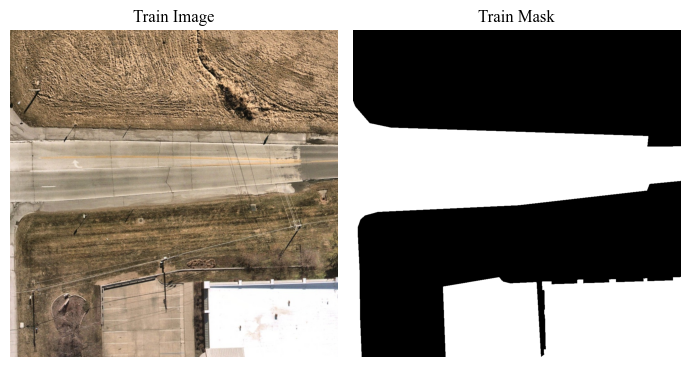

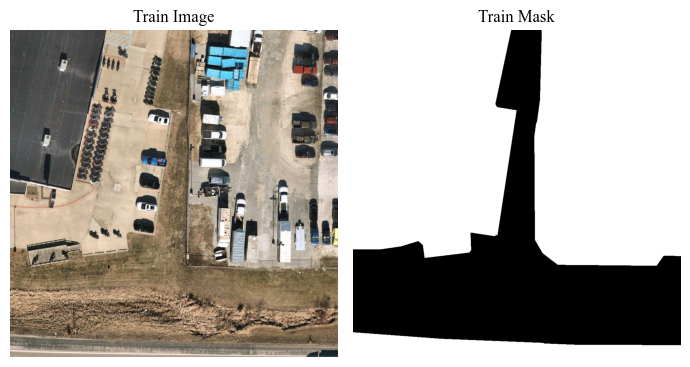

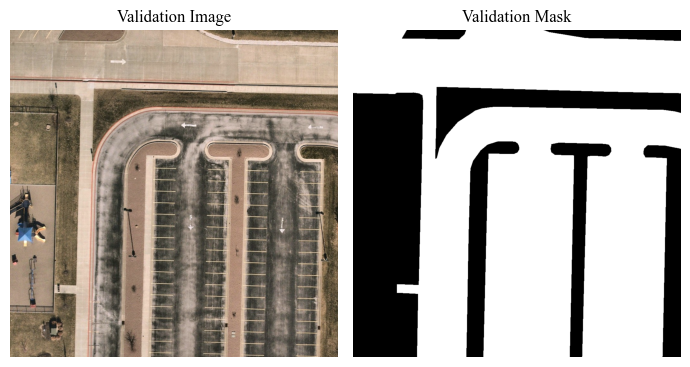

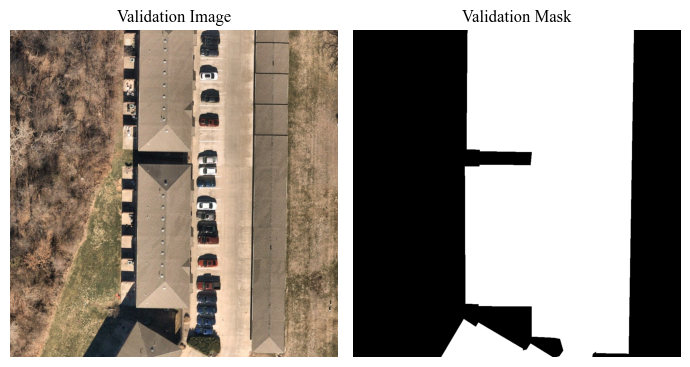

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Retrieve next batches
train_img, train_msk = train_gen.generator.__next__()
val_img, val_msk = val_gen.generator.__next__()

# Visualize random images and masks from training and validation batches
datasets = [(train_img, train_msk, "Train"), 
            (val_img, val_msk, "Validation")]

plt.rcParams['font.family'] = 'Times New Roman'
for images, masks, prefix in datasets:
    # Randomly select 2 indices from the batch
    random_indices = np.random.choice(images.shape[0], 2, replace=False)
    for i in random_indices:
        plt.figure(figsize=(7, 5))
        
        # Display Image
        plt.subplot(1, 2, 1)
        plt.imshow(images[i][:,:,[0,1,2]], cmap='gray')
        plt.title(f"{prefix} Image")
        plt.axis('off')
        
        # Display Mask
        plt.subplot(1, 2, 2)
        if num_classes > 1:
            mask = np.argmax(masks[i], axis=-1)
        else:
            mask = masks[i]
        plt.imshow(mask, cmap='gray')
        plt.title(f"{prefix} Mask")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        

## Optimizer, Loss Functions, and Metrics

Here we compile the model by specifying the optimizer, loss functions, and metrics. This is a key step in configuring how the model will learn from the data during training.

### Optimizer
The optimizer is an algorithm that adjusts the weights of the neural network to minimize the loss function. We use the Adam optimizer with a learning rate of 0.001.

### Loss Functions
Loss functions measure how well the model's predictions match the true labels. They guide the optimization process by providing a signal on how to adjust the model parameters.

Any loss function in the correct format will do the job. There are many loss functions and metrics libraries on GitHub that you can explore and implement. In our environment, we have a library called `segmentation_models` which supports various loss functions and models. Check out the `segmentation_models.losses` module. GitHub repository: [https://github.com/qubvel/segmentation_models](https://github.com/qubvel/segmentation_models)

### Callbacks
Callbacks are utilities that allow you to perform actions at various stages of the training process. The callbacks used in this setup include:

- **ModelCheckpoint**: Saves the model after every epoch if there is an improvement in the monitored metric.
- **EarlyStopping**: Stops training when a monitored metric has stopped improving to prevent overfitting.
- **CSVLogger**: Logs epoch results to a CSV file for further analysis.


In [5]:
import os
import losses_metrics
from keras.optimizers import Adam
from keras.models import load_model
from models import get_model # Models can be imported indivually from models.py
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# Initialize the parameters
input_shape = (1024, 1024, 3)
optimizer = Adam(learning_rate=1e-3)

# Loss and Metrics to track
# loss = losses_metrics.FocalDiceLoss(gamma=2.0, alpha=0.25, lambda_focal=0.3)
loss = losses_metrics.dice_loss
metrics = [losses_metrics.jaccard_index, 
           losses_metrics.dice_score]

#Keras Callbacks
checkpoint = ModelCheckpoint(model_path, monitor = 'val_jaccard_index', 
                             verbose=0, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='loss', patience=30, verbose=1)
log_csv = CSVLogger(log_path, separator=',', append=False)

# List to store the Callbacks
callbacks_list = [checkpoint, 
                  early_stop, 
                  log_csv]


## Model Compilation

The `get_model` function is documented with parameter settings that explain their purposes and how to configure them. But, any model can be defined and integrated as long as it follows the proper format and structure. `See "segnet.py" for a different model definition.` 

#### Example:
```python 
# Import segnet model from segnet.py
from segnet import segnet

# Initialize the model
model = segnet(input_shape, num_classes)
model.summary() 


In [7]:
# Compile the model
model = get_model("resunet", 
                  input_shape, 
                  filter_list=[16, 32, 64, 128, 256], 
                  num_conv_stack = 3,
                  batch_norm = True,
                  downsample_type = 'maxpool',
                  upsample_type = 'deconv',
                  bottleneck_type='conv',
                  # atrous_rates = [1, 2, 4, 6],
                  output_activation = 'sigmoid',
                  )

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "resunet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1024, 1024,   448         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 1024, 1024,   64         ['conv2d_1[0][0]']               
 rmalization)                   16)                                                         

#### Load the Saved Weights for Further Training (Skip it ahead if you're not retraining the model)

In [ ]:
# # Continue the training by loading the saved weights
# # Define the path to your model and the custom objects needed for loading
# model_name = "scSEResUNet_2023.hdf5"
# model_path = os.path.join(root_dir, "Saved_Models", model_name)

# custom_objects = {
#     'DiceLoss': losses_metrics.dice_loss,
#     'JaccardIndex': losses_metrics.jaccard_index,
#     'DiceScore': losses_metrics.dice_score
# }

# # Load the original model with custom loss and metrics
# model = load_model(model_path, custom_objects=custom_objects)

## Model Training

The weights are saved at each best validation epoch. You can choose to save the final weight by running `model.save('model_path')`.

In [ ]:
# Define the steps per epoch
train_steps_per_epoch = len(train_gen.img_list) // batch_size
val_steps_per_epoch = len(val_gen.img_list) // batch_size

# Fit the model
model.fit(
    train_gen.generator, 
    verbose=1, 
    epochs=40, 
    validation_data=val_gen.generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    callbacks=callbacks_list
) 


In [ ]:
# model.save(os.path.join(root_dir, "Saved_Models", f"final_{model_name}"))

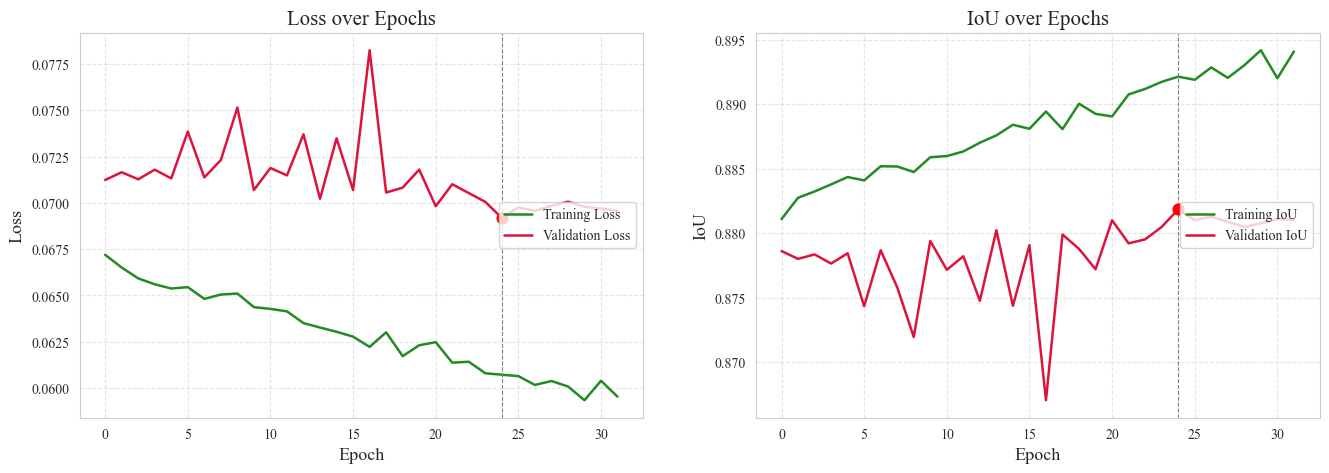

In [8]:
import pandas as pd
from utils import plot_loss_and_metric  

data = pd.read_csv(log_path)


best_iou = data['val_jaccard_index'].idxmax()
best_loss = data['val_loss'].idxmin()


plot_loss_and_metric(data, 'epoch', 'loss', 'val_loss', 'jaccard_index', 'val_jaccard_index', best_iou, best_loss)


## Loading the Test Dataset


In [9]:
from utils import load_test_datasets

# Test dataset
test_imgs_path = os.path.join(data_dir, "test", "images")
test_masks_path = os.path.join(data_dir, "test", "masks")
test_imgs, test_masks = load_test_datasets(test_imgs_path, test_masks_path, calculate_pisi=False, 
                                           calculate_ndvi=False, img_extension='.TIF',channels=None)


Processing Masks: 100%|██████████| 3459/3459 [00:11<00:00, 294.71it/s]


## Predicting Test Images

In [10]:
from utils import predict_test_images

model_name = "scSEResUNet_2023_v1.hdf5"
model_path = os.path.join(root_dir, "Trained_Models", model_name)

predictions = predict_test_images(test_imgs, model_path, threshold=0.5, augment_test=False, pred_type='threshold')

Predicting: 100%|██████████| 3459/3459 [19:38<00:00,  2.94it/s]


In [11]:
from utils import calculate_metrics_binary, plot_conf_matrix_binary 

# Calculate the mean IoU and other metrics for the test dataset
metrics_dict, conf_matrix = calculate_metrics_binary(test_masks, predictions, model_name)

Model                                              | IoU             | Precision       | Recall          | F1 Score        | Accuracy        
scSEResUNet_2023_v1.hdf5                           | 88.1862         | 92.8006         | 94.6624         | 93.7223         | 95.0171         


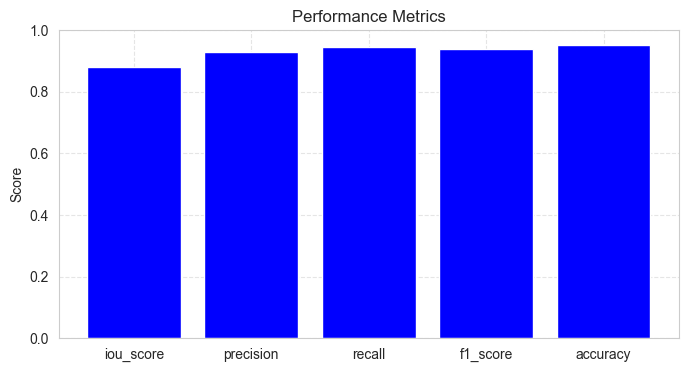

In [17]:
metrics = list(metrics_dict.keys())
values = list(metrics_dict.values())

# Creating the bar plot
plt.figure(figsize=(8, 4))
plt.bar(metrics, values, color='blue')
# plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Metrics')
plt.ylim(0, 1) 
plt.show()

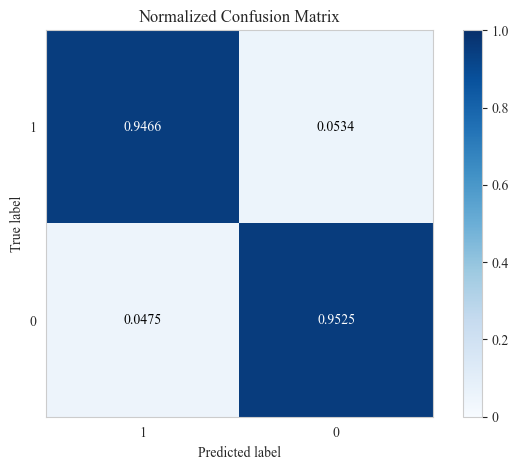

In [18]:
# Plot the normalized confusion matrix
plot_conf_matrix_binary(conf_matrix, ['1', '0'], title="Normalized Confusion Matrix")

### Visualize the predictions

- **Blue**: False Positive pixel
- **Red**: False Negative pixel

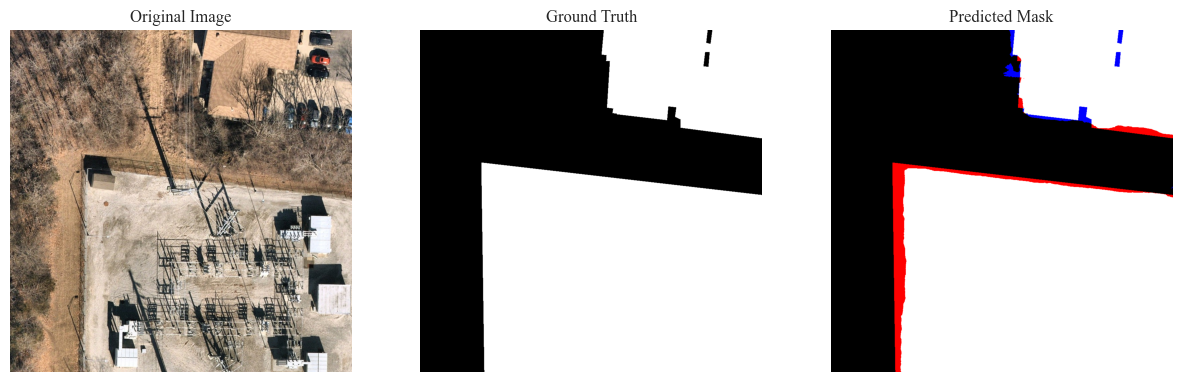

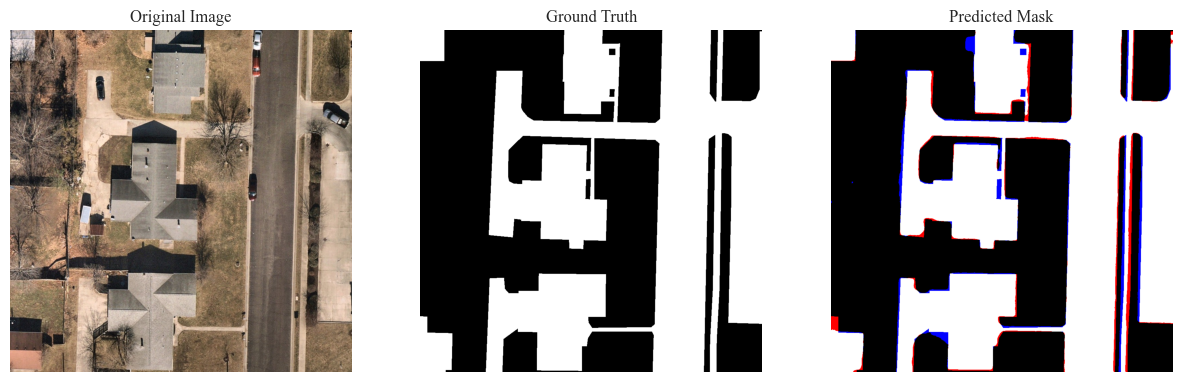

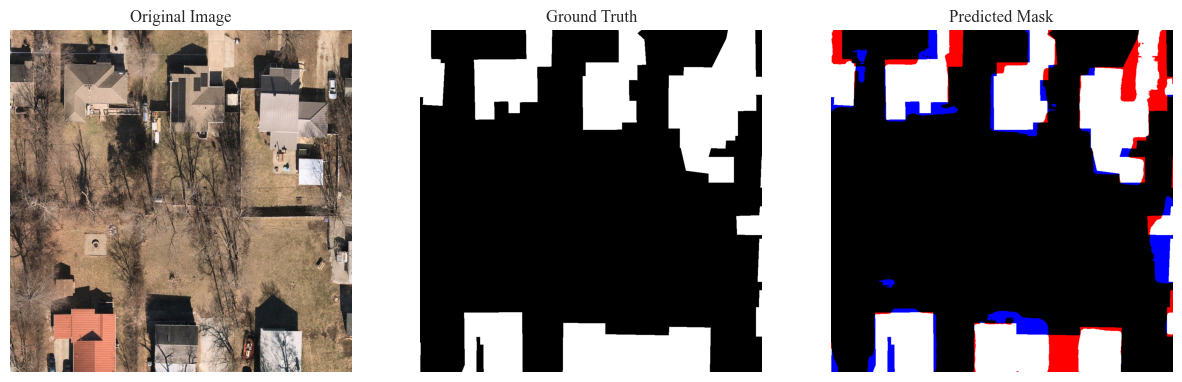

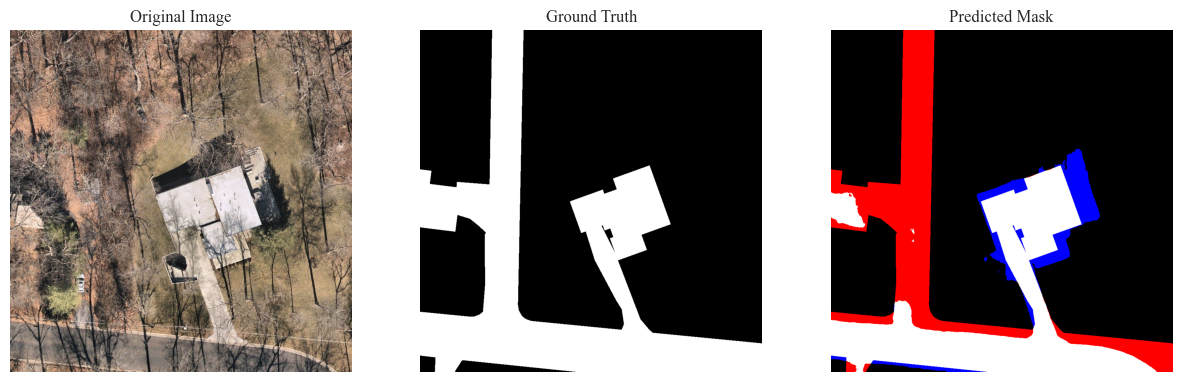

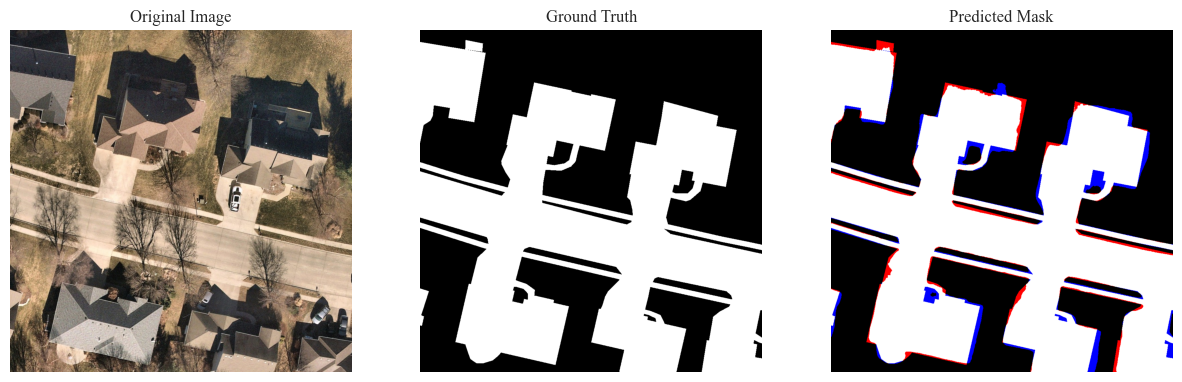

In [21]:
from utils import create_colored_mask # only for binary segmentation where the pixel values are either 0 or 1.

# Visualize a few random examples
num_examples_to_visualize = 5
random_indices = np.random.choice(len(test_imgs), num_examples_to_visualize, replace=False)

plt.rcParams['font.family'] = 'Times New Roman'
for index in random_indices:
    plt.figure(figsize=(15, 5))


    plt.subplot(1, 3, 1)
    plt.imshow(test_imgs[index][:, :, [0, 1, 2]])
    plt.title('Original Image')
    plt.axis('off')


    plt.subplot(1, 3, 2)
    plt.imshow(test_masks[index], cmap='gray')
    plt.title('Ground Truth')
    plt.axis('off')


    colored_mask = create_colored_mask(test_masks[index], predictions[index])
    plt.subplot(1, 3, 3)
    plt.imshow(colored_mask)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()


---

### Created by:  
**Anar Batmunkh**  
*Geography, MA*  
*University of Missouri, 2024*

---
